# IBM AI Enterprise Workflow Capstone

Capstone project from IB AI Enterprise Workflow Course

# Imports

In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import joblib

from visualization import show_histogram, show_correlation_matrix

DATA_DIR = './ai-workflow-capstone-master/cs-train'

# Part 1: Getting Started

There is a need to understand the business scenario in the context of available data and carry out an investigation. The goals of this part of the case study are below.

1. Assimilate the business scenario and articulate testable hypotheses.
2. State the ideal data to address the business opportunity and clarify the rationale for needing specific data.
3. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.
4. Investigate the relationship between the relevant data, the target and the business metric.
5. Articulate your findings using a deliverable with visualizations.

## 1.1 Assimilate the business scenario and articulate testable hypotheses.

We want to analyse on the revenue obtained for each year. In this way, the hypothesis that we would like to test is the following:

H: Each year the revenue increases

## 1.2 State the ideal data to address the business opportunity and clarify the rationale for needing specific data.

For analayzing that, is necessary to have a dataset with the invoice for each day, without outliers and easy to group in day, month and year.

## 1.3 Extract relevant data from multiple data sources, automating the process of data ingestion.

In this step we will extract the data provided by AAVAIL as well as cleaning it

In [2]:
df = pd.DataFrame()

data_files = [f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]
data_files = sorted(data_files)

for f in data_files:
    invoice_df = pd.read_json(os.path.join(DATA_DIR, f))
    
    # Rename column names
    invoice_df = invoice_df.rename(columns={
        'total_price': 'price',
        'StreamID': 'stream_id',
        'TimesViewed': 'times_viewed',
        'invoice': 'invoice_id'
    })
    
    df = df.append(invoice_df)

In [3]:
# Cleaning
df['invoice_id'] = df['invoice_id'].str.replace(r'\D', '')

df = df[df['price'].between(df['price'].quantile(0.01), df['price'].quantile(0.99))]

/var/folders/q1/s3qn58f110v2gm3zjsvqpdk4w74fym/T/ipykernel_98751/22704800.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['invoice_id'] = df['invoice_id'].str.replace(r'\D', '')


In [4]:
df.head()

,country,customer_id,invoice_id,price,stream_id,times_viewed,year,month,day
0,United Kingdom,13085.0,489434,6.95,85048,12,2017,11,28
1,United Kingdom,NaN,489597,8.65,22130,1,2017,11,28
2,United Kingdom,NaN,489597,1.70,22132,6,2017,11,28
3,United Kingdom,NaN,489597,1.70,22133,4,2017,11,28
4,United Kingdom,NaN,489597,0.87,22134,1,2017,11,28


## 1.4 Investigate the relationship between the relevant data, the target and the business metric.

In this step we will investigate the distribution of the variables as well as their relationship between them

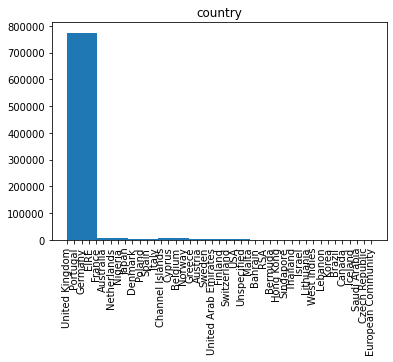

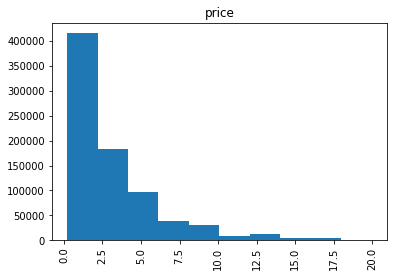

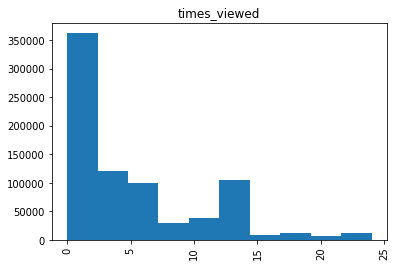

In [5]:
for col_name in df[['country', 'price', 'times_viewed']].columns:
    show_histogram(df, col_name)

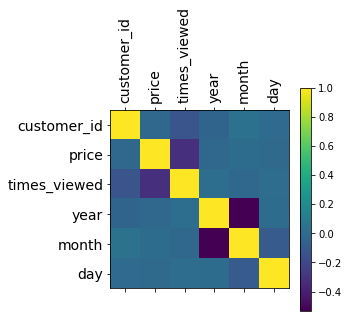

In [6]:
show_correlation_matrix(df)

## 1.5 Articulate your findings using a deliverable with visualizations.

Once we have done a simple visualization, is time for explore our hypothesis. the first step will be to group our data per year, to know how much did AAVAIL win in each country.

In [7]:
df_revenue = pd.crosstab(df['country'], df['year'], values=df['price'], aggfunc='sum', margins=True, margins_name='total')
df_revenue = df_revenue.sort_values('total', ascending=False)

df_revenue.head(11)

year,2017,2018,2019,total
country,,,,
total,159364.99,1666524.13,774741.38,2600630.50
United Kingdom,151195.66,1546147.66,705593.87,2402937.19
EIRE,2430.64,31989.79,11514.32,45934.75
Germany,1309.79,26986.92,15208.94,43505.65
France,1154.39,17319.39,12191.83,30665.61
Netherlands,384.26,6473.41,2990.24,9847.91
Spain,761.16,2832.25,4115.65,7709.06
Belgium,79.10,3783.31,3659.95,7522.36
Switzerland,37.92,3448.85,3180.71,6667.48


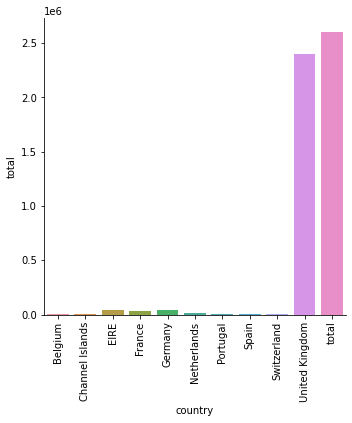

In [8]:
df_total_revenue = pd.pivot_table(df_revenue.head(11), index='country', values='total')
df_total_revenue['country'] = df_total_revenue.index
sns.catplot(x='country', y='total', data=df_total_revenue, kind='bar')
plt.xticks(rotation=90)
plt.show()

As we can see, the UK is the country that gave us the most benefits. But still, we need to know if those benefits increased in each year or not.

In [9]:
df_revenue_2 = pd.crosstab(df['year'],df['country'], values=df['price'], aggfunc='sum', margins=True, margins_name='total')
df_revenue_2 = df_revenue_2.fillna(0)
df_revenue_2 = df_revenue_2.drop('total')
df_revenue_2.head()

country,Australia,Austria,Bahrain,Belgium,Bermuda,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,...,Spain,Sweden,Switzerland,Thailand,USA,United Arab Emirates,United Kingdom,Unspecified,West Indies,total
year,,,,,,,,,,,,,,,,,,,,,
2017,59.65,151.40,0.00,79.10,0.0,0.00,0.00,171.93,803.57,0.00,...,761.16,4.85,37.92,0.00,0.0,132.71,151195.66,0.00,0.0,159364.99
2018,1938.48,1166.40,356.73,3783.31,84.7,113.71,147.51,3415.98,1533.24,0.00,...,2832.25,1955.24,3448.85,227.97,669.9,829.09,1546147.66,985.58,122.2,1666524.13
2019,2322.46,494.97,82.76,3659.95,0.0,142.60,354.55,1470.28,1055.41,31.83,...,4115.65,496.21,3180.71,0.00,74.2,77.57,705593.87,832.78,0.0,774741.38


Int64Index([2017, 2018, 2019], dtype='int64', name='year')


([<matplotlib.axis.XTick at 0x13683ffd0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

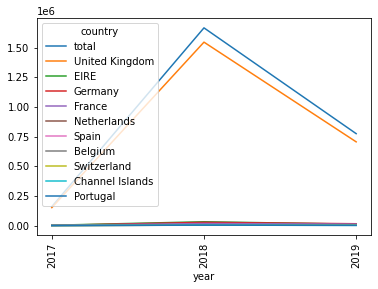

In [10]:
top_countries = df_revenue.head(11).index

df_revenue_2.index = df_revenue_2.index.astype(int)
print(df_revenue_2.index)
df_revenue_2[top_countries].plot.line()
plt.xticks([2017,2018,2019],rotation=90)

As we can see 2018 was better than 2017 but unexpectedly, 2019 was worse than 2018 in the UK and in total. As the UK and total are much higher than the rest of the countries, we will analyse more carefully the other ones.

Int64Index([2017, 2018, 2019], dtype='int64', name='year')


([<matplotlib.axis.XTick at 0x13480fa00>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

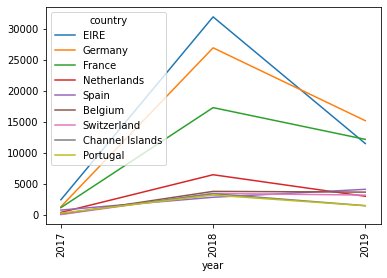

In [11]:
top_countries = df_revenue.head(11).index

df_revenue_2.index = df_revenue_2.index.astype(int)
print(df_revenue_2.index)
df_revenue_2[top_countries[2:]].plot.line()
plt.xticks([2017,2018,2019],rotation=90)

As it can be seen, the tendency of the UK and total is followed in almost every country, meaning that mostly in 2019 we made less profit than in 2018.

# Part 2: Model building and selection

There is a need to create a model for future predictions in AAVAIL. The objectives of this part are:

1. State the different modeling approaches that you will compare to address the business opportunity.
2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
3. Re-train your model on all of the data using the selected approach and prepare it for deployment.
4. Articulate your findings in a summary report.

## 2.1 State the different modeling approaches that you will compare to address the business opportunity.

In [16]:
# Getting the dataframes that we will use for training models

# df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df_clean = df[['year', 'month', 'day', 'times_viewed', 'price', 'country']]
df_clean

,year,month,day,times_viewed,price,country
0,2017,11,28,12,6.95,United Kingdom
1,2017,11,28,1,8.65,United Kingdom
2,2017,11,28,6,1.70,United Kingdom
3,2017,11,28,4,1.70,United Kingdom
4,2017,11,28,1,0.87,United Kingdom
...,...,...,...,...,...,...
42013,2019,7,31,12,0.85,United Kingdom
42014,2019,7,31,8,1.95,United Kingdom
42015,2019,7,31,12,0.83,United Kingdom
42016,2019,7,31,3,4.95,United Kingdom


In [26]:
df_daily = df_clean.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum','country':'first'}).reset_index()
df_daily

,year,month,day,times_viewed,price,country
0,2017,11,28,14890,11947.02,United Kingdom
1,2017,11,29,13914,11346.05,United Kingdom
2,2017,11,30,15603,9832.91,United Kingdom
3,2017,12,1,12395,8196.20,United Kingdom
4,2017,12,2,3266,1392.94,United Kingdom
...,...,...,...,...,...,...
490,2019,7,26,7404,3239.12,United Kingdom
491,2019,7,28,6852,2988.02,United Kingdom
492,2019,7,29,6963,3856.23,United Kingdom
493,2019,7,30,8326,4342.15,United Kingdom


<AxesSubplot:>

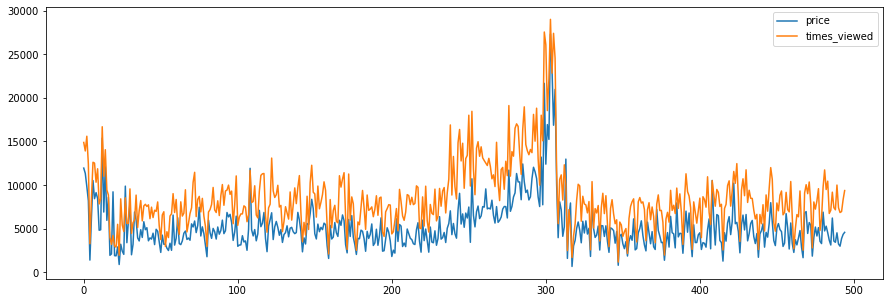

In [22]:
df_daily['price'].plot(figsize=(15, 5), legend=True)
df_daily['times_viewed'].plot(figsize=(15, 5), legend=True)

In [27]:
df_monthly = df_clean.groupby(['year', 'month']).agg({'times_viewed':'sum', 'price':'sum','country':'first'}).reset_index()
df_monthly

,year,month,times_viewed,price,country
0,2017,11,44407,33125.98,United Kingdom
1,2017,12,162226,126239.01,United Kingdom
2,2018,1,174101,114599.91,United Kingdom
3,2018,2,154841,93404.49,United Kingdom
4,2018,3,198765,124868.38,United Kingdom
5,2018,4,181555,107497.95,United Kingdom
6,2018,5,201406,125371.51,United Kingdom
7,2018,6,202342,126602.44,United Kingdom
8,2018,7,183342,108762.93,United Kingdom
9,2018,8,188496,102409.67,United Kingdom


<AxesSubplot:>

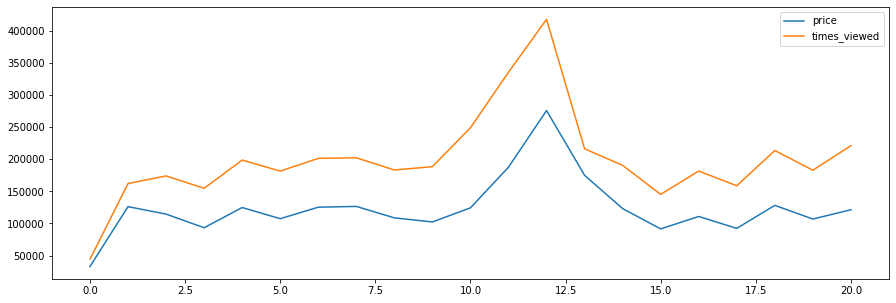

In [24]:
df_monthly['price'].plot(figsize=(15, 5), legend=True)
df_monthly['times_viewed'].plot(figsize=(15, 5), legend=True)

We will focus our predictions in daily views as price might change in the future and we don't have that many data about monthly views.

## 2.2 & 2.3 Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors and re-train your model on all of the data using the selected approach and prepare it for deployment.

Prepare the time series

In [39]:
df_daily['date'] = pd.to_datetime(df_daily[['year', 'month', 'day']])
ts_daily = df_daily[['date','times_viewed']]
ts_daily.set_index('date', inplace=True)
ts_daily = ts_daily.asfreq(freq='1D')
ts_daily['times_viewed'].interpolate(inplace = True)
ts_daily

,times_viewed
date,
2017-11-28,14890.0
2017-11-29,13914.0
2017-11-30,15603.0
2017-12-01,12395.0
2017-12-02,3266.0
...,...
2019-07-27,7128.0
2019-07-28,6852.0
2019-07-29,6963.0


Let's get the trend and seasonality of our data

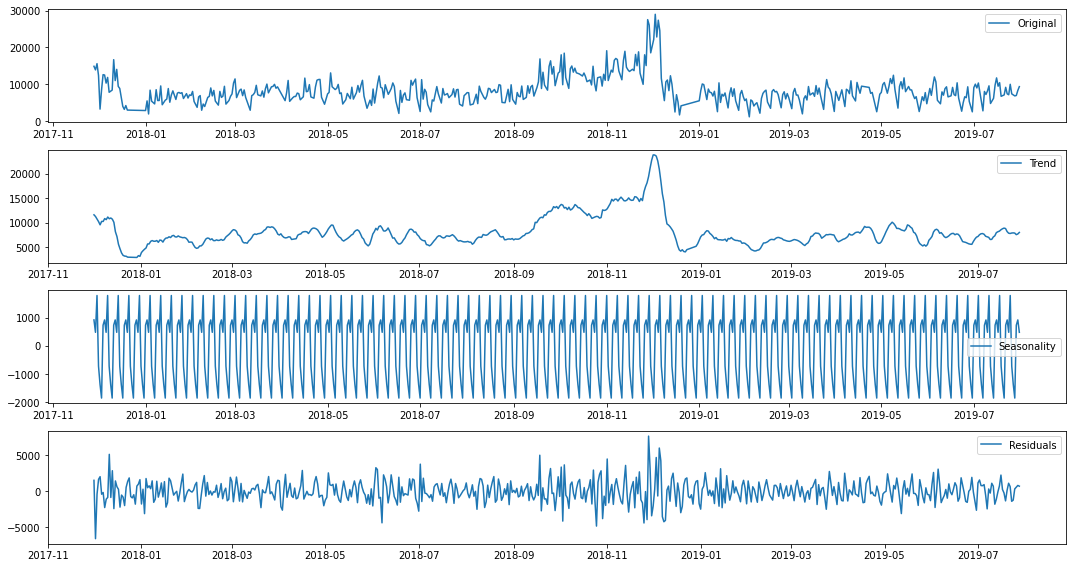

In [44]:
decomposition = seasonal_decompose(ts_daily)

plt.figure(figsize=(15, 8))
plt.subplot(411)
plt.plot(ts_daily, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [82]:
model = ARIMA(ts_daily, order=(1,1,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           times_viewed   No. Observations:                  611
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5615.620
Date:                Thu, 12 May 2022   AIC                          11237.239
Time:                        14:54:53   BIC                          11250.480
Sample:                    11-28-2017   HQIC                         11242.390
                         - 07-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4152      0.037     11.125      0.000       0.342       0.488
ma.L1         -0.8415      0.023    -35.908      0.000      -0.887      -0.796
sigma2      5.794e+06   2.25e+05     25.785      0.000    5.35e+06    6.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               170.62
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.25
Prob(H) (two-sided):                  0.71   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

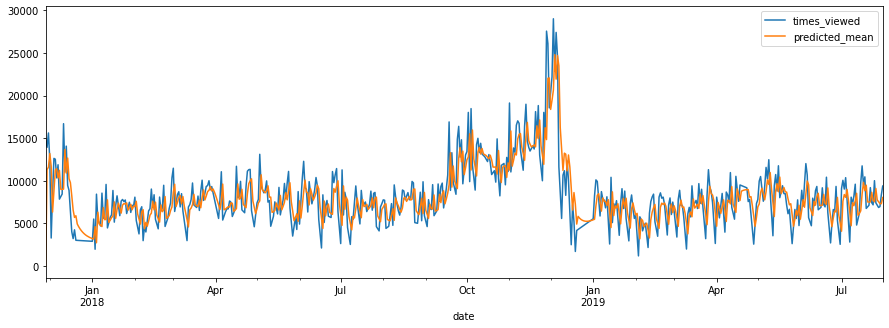

In [85]:
predictions = model.predict(start='2017-11-28', end='2019-07-31')
ts_daily.plot(figsize=(15, 5), legend=True)
predictions.plot(figsize=(15, 5), legend=True)

In [96]:
print(sum(predictions))

263183.8577889034


In [86]:
model = ExponentialSmoothing(ts_daily)
model = model.fit()
model.summary()

Dep. Variable:,endog,No. Observations:,611
Model:,ExponentialSmoothing,SSE,3746292987.310
Optimized:,True,AIC,9553.280
Trend:,None,BIC,9562.110
Seasonal:,None,AICC,9553.346
Seasonal Periods:,None,Date:,"Thu, 12 May 2022"
Box-Cox:,False,Time:,14:55:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4885951,alpha,True
initial_level,14018.009,l.0,True


<AxesSubplot:xlabel='date'>

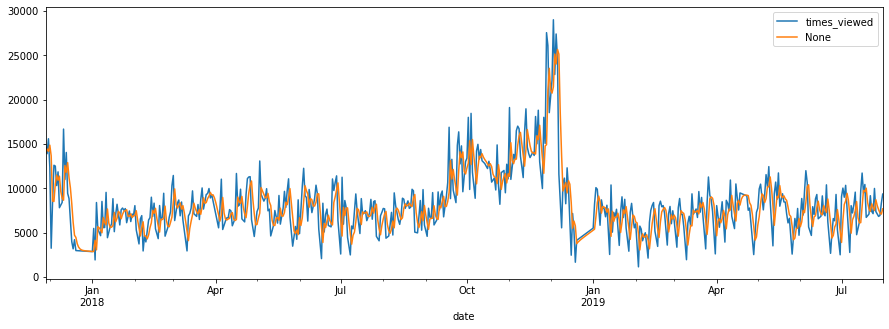

In [87]:
predictions = model.predict(start='2017-11-28', end='2019-07-31')
ts_daily.plot(figsize=(15, 5), legend=True)
predictions.plot(figsize=(15, 5), legend=True)

In [91]:
# Save model
joblib.dump(model, './models/model.joblib')

['./models/model.joblib']

## 2.4 Articulate your findings in a summary report.

As saw in the AIC metric and graphs, ExponentialSmoothing model worked better for our data than ARIMA model, therefore that will be the final model that we will deploy in our API.

# Part 3: Model production